In [1]:
# =====================
# 📦 STEP 0: IMPORTS
# =====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings

In [2]:
# =====================
# 📂 STEP 1: LOAD DATA
# =====================
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])
df = df.dropna(subset=["TOTALDEMAND", "AVAILABLEGENERATION", "INTERCONNECTORFLOWS", "RRP"])


In [3]:
# =====================
# 🔧 STEP 2: FEATURE ENGINEERING
# =====================
df = df.sort_values("SETTLEMENTDATE")
df["DEMAND_LAG5"] = df["TOTALDEMAND"].shift(1)
df["GEN_LAG5"] = df["AVAILABLEGENERATION"].shift(1)
df["RESERVE_MARGIN"] = df["AVAILABLEGENERATION"] - df["TOTALDEMAND"]
df["HOUR"] = df["SETTLEMENTDATE"].dt.hour
df["WEEKDAY"] = df["SETTLEMENTDATE"].dt.weekday
df["ROLLING_RRP"] = df["RRP"].rolling(window=6, min_periods=1).mean()


Correlation (overall): 0.21948479523625428


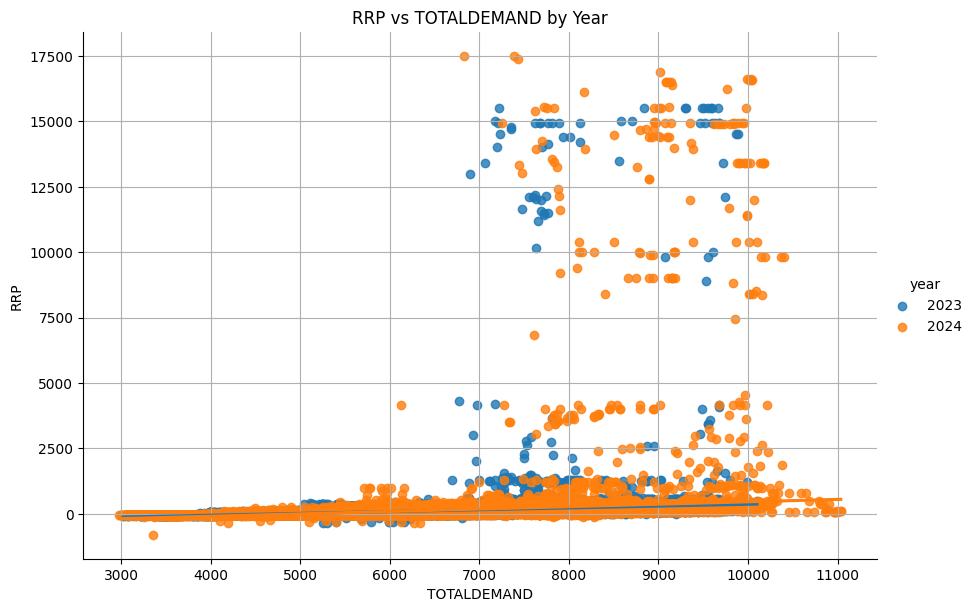

In [4]:
# =====================
# 🔍 STEP 3: BASELINE DEMAND-PRICE CORRELATION
# =====================
print("Correlation (overall):", df[["RRP", "TOTALDEMAND"]].corr().iloc[0,1])
sns.lmplot(data=df, x="TOTALDEMAND", y="RRP", hue="year", height=6, aspect=1.5)
plt.title("RRP vs TOTALDEMAND by Year")
plt.grid()
plt.show()

In [5]:
# =====================
# 🧪 STEP 4: RULE-BASED LABEL
# =====================
df["is_anomaly"] = df["RRP"] > 1000

In [6]:
# =====================
# 🤖 STEP 5: UNSUPERVISED - ISOLATION FOREST
# =====================
features_unsup = [
    "TOTALDEMAND", "AVAILABLEGENERATION", "INTERCONNECTORFLOWS",
    "RESERVE_MARGIN", "DEMAND_LAG5", "GEN_LAG5"
]
X_unsup = df[features_unsup].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsup)

iso_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df.loc[X_unsup.index, "iso_anomaly"] = iso_model.fit_predict(X_scaled) == -1


In [8]:
# =====================
# 🤖 STEP 6: SUPERVISED - RANDOM FOREST
# =====================
features_sup = features_unsup + ["INTERVENTION", "HOUR", "WEEKDAY"]
X_sup = df[features_sup].dropna()
y_sup = df.loc[X_sup.index, "is_anomaly"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_sup, y_sup, test_size=0.3, stratify=y_sup, random_state=42)

model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63062
           1       0.77      0.36      0.49       134

    accuracy                           1.00     63196
   macro avg       0.89      0.68      0.74     63196
weighted avg       1.00      1.00      1.00     63196


Confusion Matrix:
[[63048    14]
 [   86    48]]

ROC AUC Score: 0.9530278067971013


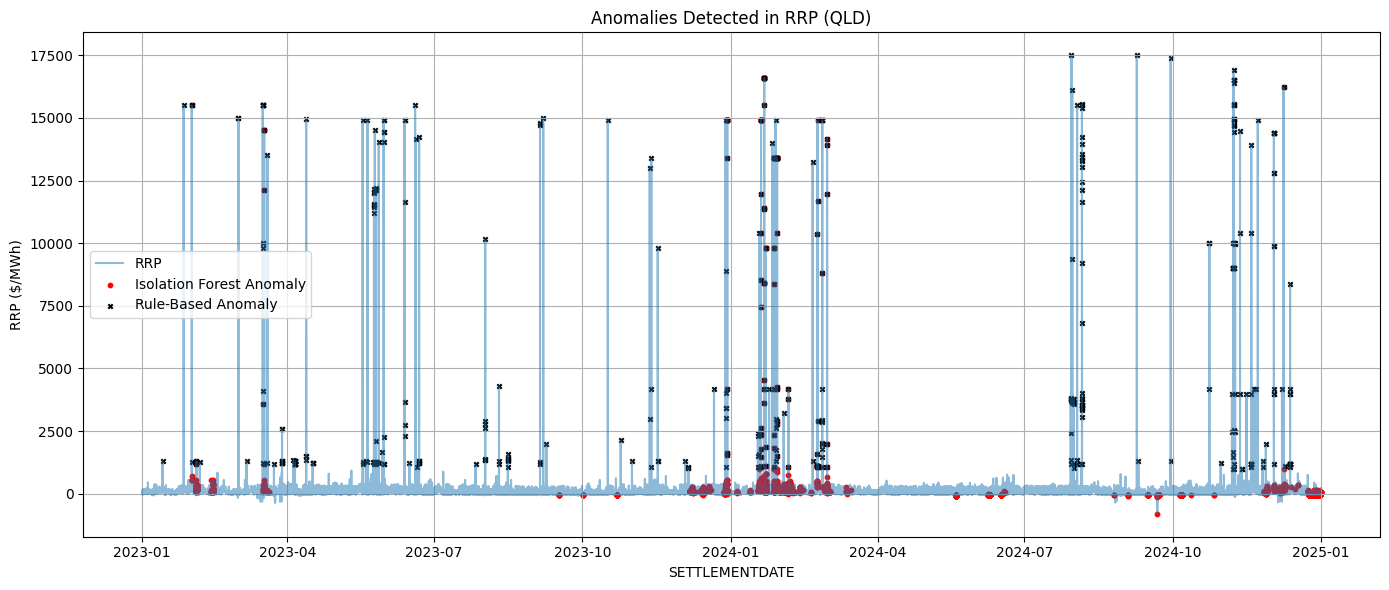

In [9]:
# =====================
# 📊 STEP 7: VISUAL INSIGHTS
# =====================
plt.figure(figsize=(14, 6))
plt.plot(df["SETTLEMENTDATE"], df["RRP"], label="RRP", alpha=0.5)
plt.scatter(df[df["iso_anomaly"] == True]["SETTLEMENTDATE"],
            df[df["iso_anomaly"] == True]["RRP"],
            color="red", s=10, label="Isolation Forest Anomaly")
plt.scatter(df[df["is_anomaly"] == True]["SETTLEMENTDATE"],
            df[df["is_anomaly"] == True]["RRP"],
            color="black", s=10, label="Rule-Based Anomaly", marker="x")
plt.title("Anomalies Detected in RRP (QLD)")
plt.xlabel("SETTLEMENTDATE")
plt.ylabel("RRP ($/MWh)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [12]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Select and scale features
features = ["TOTALDEMAND", "AVAILABLEGENERATION", "INTERCONNECTORFLOWS"]
df_lof = df.dropna(subset=features).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_lof[features])

# Fit LOF
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
df_lof["lof_anomaly"] = lof.fit_predict(X_scaled) == -1

# Map back to main dataframe
df["lof_anomaly"] = False
df.loc[df_lof.index, "lof_anomaly"] = df_lof["lof_anomaly"]


/var/folders/8l/8dts48fs5f38b99q0jpv77ph0000gn/T/ipykernel_24639/1623512520.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count_df, y="Method", x="Count", palette="Blues_d")


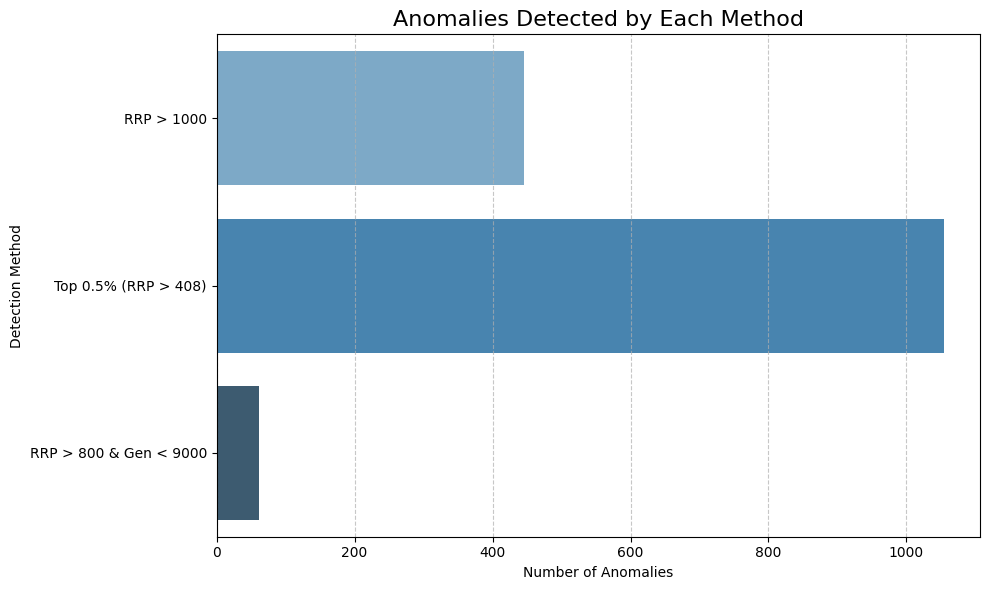

In [14]:
# Bar Chart: Anomalies Detected per Method

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (replace path if needed)
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

# Define anomaly detection methods (recalculate if not already included)
df = df.dropna(subset=["RRP", "AVAILABLEGENERATION"])
df["anomaly_r1000"] = df["RRP"] > 1000
percentile_995 = df["RRP"].quantile(0.995)
df["anomaly_percentile"] = df["RRP"] > percentile_995
df["anomaly_combo"] = (df["RRP"] > 800) & (df["AVAILABLEGENERATION"] < 9000)

# Optional: if ML anomaly labels exist
df["anomaly_lof"] = df.get("lof_anomaly", False)
df["anomaly_iso"] = df.get("iso_anomaly", False)

# Count anomalies
anomaly_counts = {
    "RRP > 1000": df["anomaly_r1000"].sum(),
    "Top 0.5% (RRP > {:.0f})".format(percentile_995): df["anomaly_percentile"].sum(),
    "RRP > 800 & Gen < 9000": df["anomaly_combo"].sum(),
}

# Convert to DataFrame for plotting
count_df = pd.DataFrame.from_dict(anomaly_counts, orient='index', columns=['Count']).reset_index()
count_df.columns = ['Method', 'Count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=count_df, y="Method", x="Count", palette="Blues_d")
plt.title("Anomalies Detected by Each Method", fontsize=16)
plt.xlabel("Number of Anomalies")
plt.ylabel("Detection Method")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
